In [27]:
from PIL import Image
import numpy as np
import pylab as pl
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import joblib
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
import pandas as pd


In [2]:
def Load_data():
    # Load the data
    # Path: data_processing.ipynb
    # Return: data, label
    Vectors = np.loadtxt('./digits4000_txt/digits4000_txt/digits4000_digits_vec.txt')
    Labels = np.loadtxt('./digits4000_txt/digits4000_txt/digits4000_digits_labels.txt').reshape(-1,1)
    train_X,test_X,train_y,test_y = train_test_split(Vectors, Labels, test_size=0.5)
    return train_X,test_X,train_y,test_y

In [3]:
train_X, test_X, train_y, test_y = Load_data()

SIFT features extraction

In [36]:
def Trans_data2img(x_img):
    # transform the nparray into cv image in gray
    image = Image.fromarray(x_img.reshape(28,28).astype(np.uint8))
    img = cv.cvtColor(np.asarray(image),cv.COLOR_RGB2BGR)
    return img


def SIFT_extraction(img):
    sift = cv.SIFT_create()
    kps, features = sift.detectAndCompute(img, None)
    return features

def Learn_vocabulary(features, y, K=2000):
    # K is number of the clusters
    #set the convergence criteria for kmeans
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 20, 0.1)
    #set the initail centroids for kmeans
    flags = cv.KMEANS_RANDOM_CENTERS

    compactness, labels, centroids = cv.kmeans(features, K, y, criteria, 20, flags)
    return centroids


def Set_centroids(X, y):
    features = np.float32([]).reshape(0, 128)
    for x_img in X:
        try:
            img = Trans_data2img(x_img)
            # extract the SIFT features
            img_features = SIFT_extraction(img)
            features = np.append(features, img_features, axis=0)
        except:
            pl.imshow(img)
    #learn the centroids by kmeans
    centroids = Learn_vocabulary(features, y)
    # save the centroids for training
    filename = "./SIFT_FX/SIFT_centroids.npy"
    np.save(filename, centroids)
    print('vocabular package:',centroids.shape)
    return centroids

def Get_featureVec(features, centers, K=2000):
    featureVec = np.zeros((1, K))
    for feature in features:
        feature = np.float32(feature)
        index = (np.sum((centers - feature) ** 2, axis=1)).argmin()
        featureVec[0][index] += 1
    return featureVec

def Get_Vecs_from_SIFT(X, y, K=2000):
    centroids = np.load('./SIFT_FX/SIFT_centroids.npy')
    SIFT_vecs = np.float32([]).reshape(0, K)
    labels = np.float32([])
    for i in range(X.shape[0]):
        try:
            img = Trans_data2img(X[i])
            # extract the SIFT features
            img_features = SIFT_extraction(img)
            # get the feature vector
            img_vec = Get_featureVec(img_features, centroids)
            SIFT_vecs = np.append(SIFT_vecs, img_vec, axis=0)
            labels = np.append(labels, y[i])
        except:
            pl.imshow(img)
    print('data_vec:',SIFT_vecs.shape)
    print('image features vector done!')
    return SIFT_vecs, labels   


PCA

LDA

In [29]:
def SVM_train(SIFT_vec,labels):

    clf = svm.SVC(decision_function_shape='ovo')

    clf.fit(SIFT_vec,labels)
    joblib.dump(clf, './SIFT_FX/SIFT_SVM_model.m')

def SVM_test(SIFT_vec,labels):
    clf = joblib.load('./SIFT_FX/SIFT_SVM_model.m')
    y_pred = clf.predict(SIFT_vec)
    print('accuracy:',accuracy_score(labels,y_pred))    


vocabular package: (2000, 128)


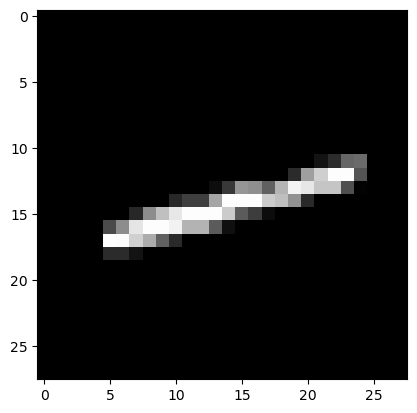

In [37]:
centroids = Set_centroids(train_X, train_y)

In [35]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(train_X, train_y)
y_pred  = clf.predict(test_X)
print('accuracy:',accuracy_score(test_y,y_pred))

c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.9375


data_vec: (1968, 2000)
image features vector done!
data_vec: (1953, 2000)
image features vector done!
accuracy: 0.6666666666666666


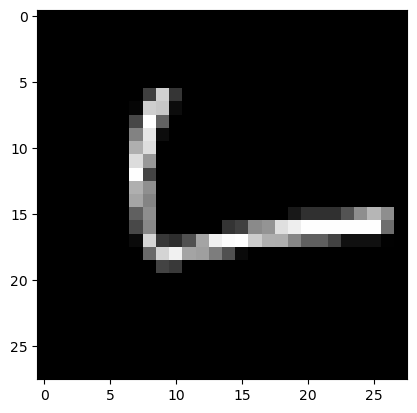

In [38]:
if __name__ == '__main__':
    SIFT_vec, labels = Get_Vecs_from_SIFT(train_X, train_y)
    stdSlr = StandardScaler().fit(SIFT_vec)
    im_features = stdSlr.transform(SIFT_vec)
    SVM_train(im_features, labels)
    SIFT_vec, labels = Get_Vecs_from_SIFT(test_X, test_y)

    stdSlr = StandardScaler().fit(SIFT_vec)
    im_features = stdSlr.transform(SIFT_vec)
    SVM_test(im_features, labels)